In [1]:
import psycopg2
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
conn = psycopg2.connect(host="postgres", port = 5432, database="production", user="user", password="password")

In [3]:
employees = pd.read_sql_query("select * from employees", conn)

In [4]:
employees.head()

,id,code,first_name,last_name,middle_name,hire_date,user_id,color,compensation_type,last_modified
0,85,0436,Patrick,Roberts,J,2020-04-20,28,#1f78b4,None,2020-07-09 14:59:03.967084
1,87,8540,Joel,Radecki,,2020-05-05,29,#e31a1c,None,2020-07-09 14:59:03.978624
2,88,8037,Bryce,Hall,,2020-05-15,30,#ff7f00,None,2020-07-09 14:59:03.990813
3,89,1414,Erik,Staebell,N,2020-05-26,31,#6a3d9a,None,2020-07-09 14:59:04.002775
4,90,1280,Michael,Bowers,F,2020-06-01,32,#1f78b4,None,2020-07-09 14:59:04.014802


In [5]:
employees_map = dict(zip(employees['id'], employees['first_name'].str.lower().str[0] + employees['last_name'].str.lower()))

In [6]:
dataset = pd.read_sql_query('''
    select
        employee_id,
        extract(epoch from cast(date_start as time)) as date_start,
        extract(epoch from duration) as duration
    from timeclock_shifts_view
    where date_stop is not null
    order by date_stop desc, date_start desc
''', conn)

In [7]:
dataset['employee_id'] = dataset['employee_id'].map(employees_map)

In [8]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,date_start,duration,ajolls,aplewa,arichardson,bbauer,bhall,bplewa,caures,clowe,...,mdollas-halbach,nhaefner,plewandowski,proberts,rhurd,rmawhinney,rsteiner,szagrobelny,tharling,thorn
3990,37620.0,30754.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3991,42900.0,18360.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3992,32940.0,31680.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3993,32100.0,30629.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3994,41520.0,19757.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape, test_dataset.shape)

(3196, 31) (799, 31)


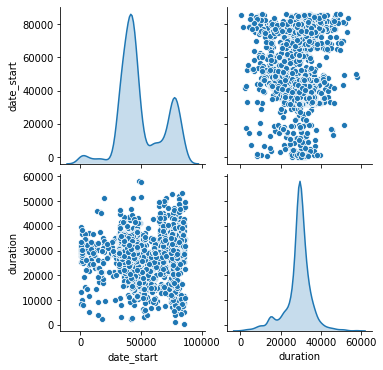

In [10]:
sns.pairplot(train_dataset[["date_start", "duration"]], diag_kind="kde")

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("duration")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
date_start,3196.0,49761.166771,18579.589037,296.0,38305.0,43458.0,66295.0,86208.0
ajolls,3196.0,0.025970,0.159071,0.0,0.0,0.0,0.0,1.0
aplewa,3196.0,0.055695,0.229367,0.0,0.0,0.0,0.0,1.0
arichardson,3196.0,0.016270,0.126533,0.0,0.0,0.0,0.0,1.0
bbauer,3196.0,0.055695,0.229367,0.0,0.0,0.0,0.0,1.0
bhall,3196.0,0.008761,0.093204,0.0,0.0,0.0,0.0,1.0
bplewa,3196.0,0.055382,0.228760,0.0,0.0,0.0,0.0,1.0
caures,3196.0,0.011264,0.105549,0.0,0.0,0.0,0.0,1.0
clowe,3196.0,0.038173,0.191643,0.0,0.0,0.0,0.0,1.0
dgasiewicz,3196.0,0.054756,0.227539,0.0,0.0,0.0,0.0,1.0


In [12]:
train_labels = train_dataset.pop('duration') # used to identify predicted value
test_labels = test_dataset.pop('duration')

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________


In [44]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:24071922.0000,  mae:3233.5486,  mse:24071922.0000,  val_loss:24836460.0000,  val_mae:3342.4648,  val_mse:24836460.0000,  
....................................................................................................
Epoch: 100, loss:23894470.0000,  mae:3222.4875,  mse:23894470.0000,  val_loss:24602766.0000,  val_mae:3323.6753,  val_mse:24602766.0000,  
....................................................................................................
Epoch: 200, loss:23755730.0000,  mae:3206.8083,  mse:23755730.0000,  val_loss:24460470.0000,  val_mae:3317.3633,  val_mse:24460470.0000,  
....................................................................................................
Epoch: 300, loss:23696474.0000,  mae:3196.5481,  mse:23696474.0000,  val_loss:24334018.0000,  val_mae:3303.7988,  val_mse:24334018.0000,  
....................................................................................................
Epoch: 400, loss:23622090.0000,  mae:3193

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,24067496.0,3244.868652,24067496.0,24918828.0,3340.032715,24918828.0,995
996,24074422.0,3237.284912,24074422.0,24853348.0,3339.845703,24853348.0,996
997,24077494.0,3237.354248,24077494.0,24826562.0,3338.708496,24826562.0,997
998,24075228.0,3237.069824,24075228.0,24871796.0,3341.621582,24871796.0,998
999,24079456.0,3239.826172,24079456.0,24850828.0,3340.218262,24850828.0,999


Text(0, 0.5, 'MAE [MPG]')

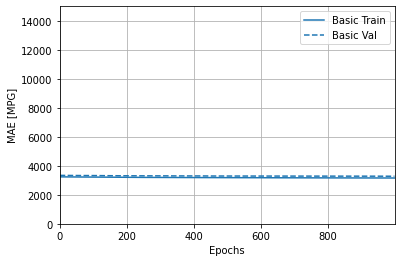

In [45]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 15000])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

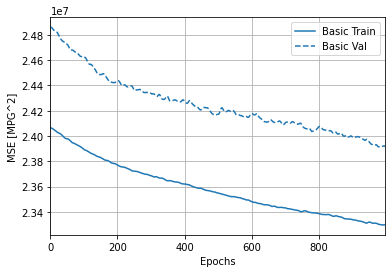

In [46]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [MPG^2]')

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} Seconds".format(mae))

25/25 - 0s - loss: 28055486.0000 - mae: 3399.2732 - mse: 28055486.0000
Testing set Mean Abs Error: 3399.27 Seconds


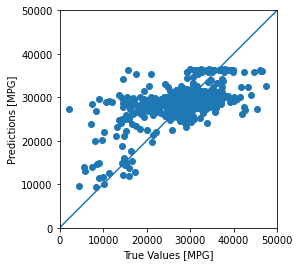

In [20]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

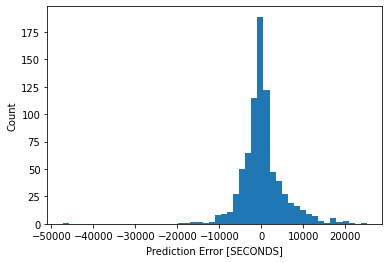

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [SECONDS]")
_ = plt.ylabel("Count")

In [23]:
test_date_start = datetime(2020, 2, 5, 12)
def get_seconds(dt):
    t = dt.time()
    s = (t.hour * 60 + t.minute) * 60 + t.second
    return s

#employee_id = 57

def make_prediction(dt, employee_id):
    test = pd.DataFrame(columns=normed_test_data.columns)
    val = pd.DataFrame([{'employee_id': employee_id, 'date_start': get_seconds(dt)}])
    val['employee_id'] = val['employee_id'].map(employees_map)
    val = pd.get_dummies(val, prefix='', prefix_sep='')

    for col in normed_test_data.columns:
        if col not in val:
            val[col] = 0

    val = val[[c for c in normed_test_data.columns]]
    val = norm(val)

    return model.predict(val).flatten()
employee_id = 80

prediction = make_prediction(test_date_start, employee_id)
'when starting at {}: {:.3} hours'.format(test_date_start, prediction[0] / 3600)

'when starting at 2020-02-05 12:00:00: 4.2 hours'

In [54]:
target_employee = employees.loc[employees['first_name'] == 'Brandon'].iloc[0]
target_employee

id                                           51
code                                       4791
first_name                              Brandon
last_name                                 Bauer
middle_name                                    
hire_date                            2012-10-28
user_id                                       3
color                                   #33a02c
compensation_type                          None
last_modified        2020-07-09 14:59:03.661626
Name: 6, dtype: object

Text(0, 0.5, 'Length of shift (hours)')

<Figure size 432x288 with 0 Axes>

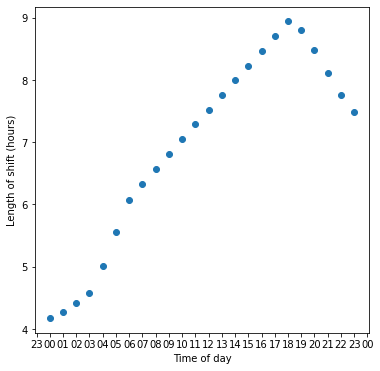

In [55]:
plt.clf()
plt.figure(figsize=(6,6))
base = datetime(2020, 1, 1)
xx = np.array([base + i * timedelta(hours=1) for i in range(24)])
f = lambda dt: make_prediction(dt, target_employee['id'])
yy = np.vectorize(f)(xx) / 3600

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.scatter(xx, yy)
plt.xlabel('Time of day')
plt.ylabel('Length of shift (hours)')